# Chat Intents Tutorial

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

from hyperopt import hp

import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

In [2]:
import chatintents
from chatintents import ChatIntents

In [3]:
%load_ext autoreload
%autoreload 2

## Load data and pre-trained models

In [5]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')[['text', 'category']]
data_sample.head()

,text,category
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit
4,Are there ways for other people to send me money?,receiving_money


In [6]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

In [8]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 230.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 450.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 680.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 910.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [9]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('all-distilroberta-v1')
#model_st1 = SentenceTransformer('paraphrase-mpnet-base-v2')
#model_st2 = SentenceTransformer('paraphrase-distilroberta-base-v2')
#model_st3 = SentenceTransformer('stsb-mpnet-base-v2')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    
    return embeddings

In [11]:
embeddings_use = embed(model_use, 'use', all_intents)
embeddings_use.shape

TensorShape([1000, 512])

In [12]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
embeddings_st1.shape

(1000, 768)

In [13]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
embeddings_st2.shape

(1000, 384)

In [14]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)
embeddings_st3.shape

(1000, 768)

In [15]:
model_use = ChatIntents(embeddings_use, 'use')
model_st1 = ChatIntents(embeddings_st1, 'st1')
model_st2 = ChatIntents(embeddings_st2, 'st2')
model_st3 = ChatIntents(embeddings_st3, 'st3')

## Results with default hyperparameters

In [16]:
clusters_default = model_st1.generate_clusters(n_neighbors = 15, 
                                 n_components = 5, 
                                 min_cluster_size = 5, 
                                 min_samples = None,
                                 random_state=42)

In [17]:
labels_def, cost_def = model_st1.score_clusters(clusters_default)
print(labels_def)
print(cost_def)

56
0.146


## Tuning hyperparameters

### Random hyperparameter search

In [18]:
space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,15),
        "min_samples": range(2,15)
    }

random_st1 = model_st1.random_search(space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
random_st1.head(20)

,run_id,n_neighbors,n_components,min_cluster_size,min_samples,label_count,cost
14,14,15,3,7,2,60,0.086
82,82,15,4,6,2,67,0.091
75,75,14,6,14,2,34,0.093
38,38,14,4,10,3,44,0.094
12,12,13,3,10,5,38,0.095
39,39,14,3,5,3,73,0.097
13,13,13,3,13,5,31,0.097
30,30,12,4,12,8,35,0.101
90,90,12,4,9,7,42,0.103
48,48,12,3,5,2,86,0.108


### Bayesian optimization with Hyperopt

In [20]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "min_samples": None,
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [21]:
model_use.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|██████████| 100/100 [05:21<00:00,  3.21s/trial, best loss: 0.097]            
best:
{'min_cluster_size': 4, 'min_samples': None, 'n_components': 12, 'n_neighbors': 3, 'random_state': 42}
label count: 79


In [22]:
model_use.best_params

{'min_cluster_size': 4,
 'min_samples': None,
 'n_components': 12,
 'n_neighbors': 3,
 'random_state': 42}

In [23]:
model_use.trials.best_trial

{'state': 2,
 'tid': 89,
 'spec': None,
 'result': {'loss': 0.097, 'label_count': 79, 'status': 'ok'},
 'misc': {'tid': 89,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [89],
   'n_components': [89],
   'n_neighbors': [89]},
  'vals': {'min_cluster_size': [2], 'n_components': [9], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 9, 27, 16, 52, 11, 893000),
 'refresh_time': datetime.datetime(2021, 9, 27, 16, 52, 14, 286000)}

In [24]:
model_st1.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)                                                             

100%|██████████| 100/100 [06:20<00:00,  3.80s/trial, best loss: 0.075]
best:
{'min_cluster_size': 7, 'min_samples': None, 'n_components': 8, 'n_neighbors': 4, 'random_state': 42}
label count: 47


In [25]:
model_st2.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|██████████| 100/100 [04:48<00:00,  2.89s/trial, best loss: 0.067]
best:
{'min_cluster_size': 7, 'min_samples': None, 'n_components': 14, 'n_neighbors': 4, 'random_state': 42}
label count: 43


In [26]:
model_st3.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|██████████| 100/100 [05:09<00:00,  3.09s/trial, best loss: 0.059]
best:
{'min_cluster_size': 4, 'min_samples': None, 'n_components': 14, 'n_neighbors': 3, 'random_state': 42}
label count: 83


## Visually inspect clusters

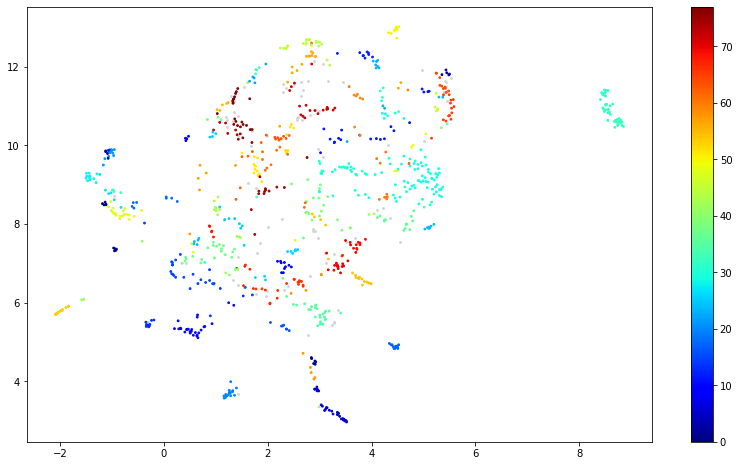

In [27]:
model_use.plot_best_clusters()

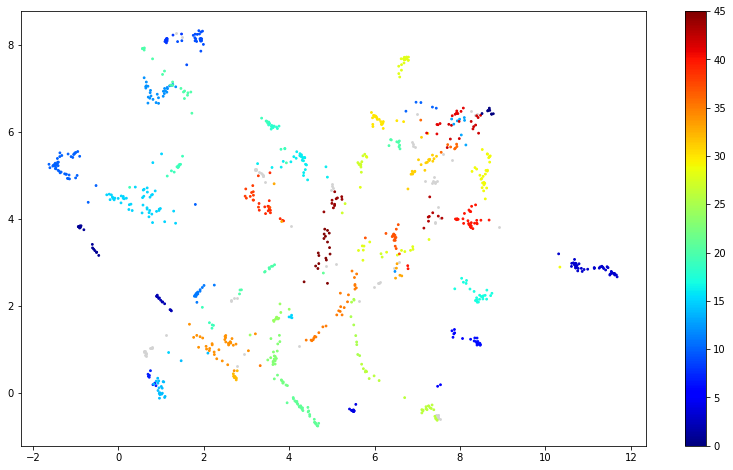

In [28]:
model_st1.plot_best_clusters()

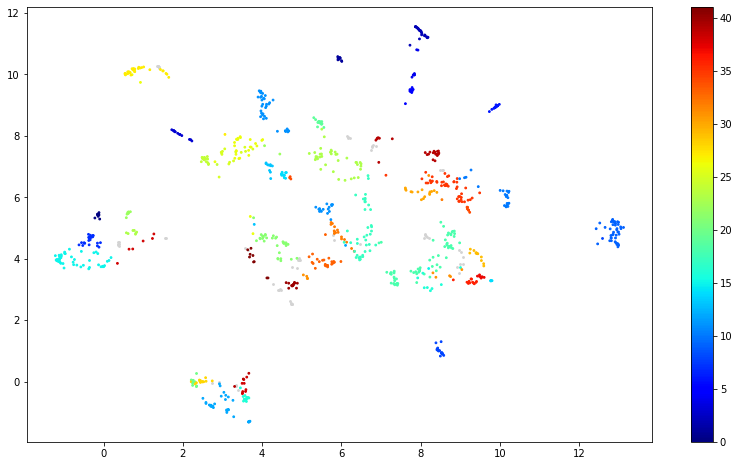

In [29]:
model_st2.plot_best_clusters()

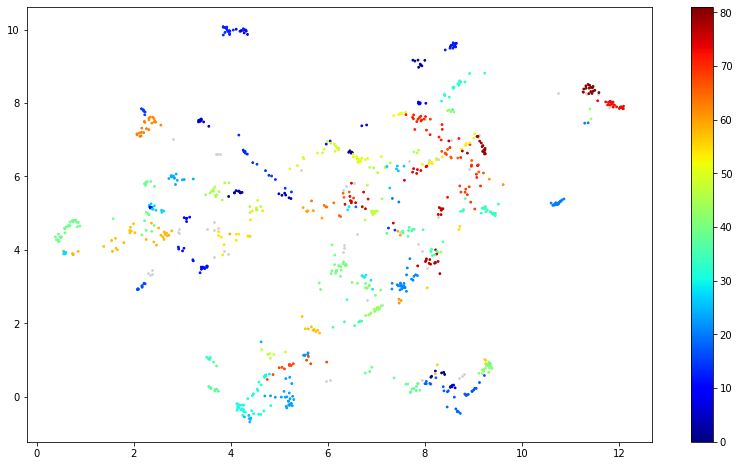

In [30]:
model_st3.plot_best_clusters()

## Apply labels

In [45]:
%%time

df_summary, labeled_docs = model_st1.apply_and_summarize_labels(data_sample[['text']])

CPU times: user 22.4 s, sys: 2.07 s, total: 24.5 s
Wall time: 26 s


In [46]:
df_summary.head()

,label_st1,count,label
0,-1,75,declined_card_transfer
16,15,55,use_account_card_auto
11,10,49,pending_money_account
4,3,46,help_refund_statement
21,20,42,need_money_country_currency


In [47]:
labeled_docs.head()

,text,label_st1,label
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,32,expect_card_week
1,I got charged a fee that shouldn't be there from my cash,16,charged_fee_withdrawal_cash
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,16,charged_fee_withdrawal_cash
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,30,deposited_money_account_cash
4,Are there ways for other people to send me money?,10,pending_money_account


## Evaluate clustering performance using ground truth labels

### Comparing multiple models

In [34]:
models = [model_use, model_st1, model_st2, model_st3]

df_comparison, labeled_docs_all_models = chatintents.evaluate_models(data_sample[['text', 'category']], models)

In [35]:
df_comparison

,Model,ARI,NMI
1,st1,0.412,0.780
3,st3,0.390,0.777
2,st2,0.357,0.750
0,use,0.268,0.725


In [36]:
labeled_docs_all_models.sample(5)

,text,category,label_use,label_st1,label_st2,label_st3
954,The amount of cash I selected to withdraw is different than what I received.,wrong_amount_of_cash_received,-1,44,20,36
314,Do I get charged for a top up from a European bank?,top_up_by_card_charge,43,19,41,57
300,Where do we mail the card?,order_physical_card,67,34,26,39
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,35,34,26,-1
78,I can't see my top up in my wallet!,topping_up_by_card,-1,10,15,31


In [44]:
labeled_docs_all_models[labeled_docs_all_models['label_use']==2]

,text,category,label_use,label_st1,label_st2,label_st3
44,What are the countries you have offices in?,country_support,2,20,12,19
279,What countries are you available in?,country_support,2,20,12,19
295,What are the countries that you operate in?,country_support,2,20,12,19
503,Which countries do you operate in,country_support,2,20,12,19
600,How do I know which countries you provide service in?,country_support,2,20,12,19
898,I would like to know the countries you are offer services in?,country_support,2,20,12,19


In [41]:
labeled_docs_all_models[labeled_docs_all_models['category']=='card_about_to_expire']

,text,category,label_use,label_st1,label_st2,label_st3
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,35,34,26,-1
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,35,34,26,-1
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,9,34,13,58
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,9,34,13,58
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,9,34,13,58
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,9,34,13,58
551,Where can I have a new bank card sent to China?,card_about_to_expire,35,34,26,-1
584,How do I get a new expiration date?,card_about_to_expire,9,34,13,58
605,Are there any express fees if i want my new card faster?,card_about_to_expire,-1,34,13,57
646,My card is almost going to expire.,card_about_to_expire,9,34,13,58


### Evaluating labels from a single model to ground truth

In [39]:
chatintents.top_cluster_category(labeled_docs, 
                                 data_sample[['text', 'category']], 
                                 'text',
                                 df_summary).head(20)

,label_st1,count,label,top_ground_category,top_cat_count,perc_top_cat
0,-1,75,declined_card_transfer,extra_charge_on_statement,10,13
1,15,55,use_account_card_auto,automatic_top_up,15,27
2,10,49,pending_money_account,pending_top_up,14,29
3,3,46,help_refund_statement,Refund_not_showing_up,26,57
4,20,42,need_money_country_currency,atm_support,10,24
5,28,36,find_source_fund_account,verify_source_of_funds,17,47
6,34,35,like_card_cost,card_about_to_expire,14,40
7,40,30,tell_payment_card,reverted_card_payment?,14,47
8,21,30,need_pin_card,change_pin,13,43
9,12,30,use_currency_app,fiat_currency_support,10,33
